In [2]:
import sys

import numpy as np
import pandas as pd
import datetime
import time

# music api imports
import spotipy
import spotipy.util as util
import billboard
import pygn
import pylast

import requests
import re
from bs4 import BeautifulSoup
from time import sleep
import pickle
import cPickle as pk

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid", {'axes.grid' : False})

In [3]:
from sklearn import cross_validation, datasets, linear_model, grid_search, metrics, ensemble, tree
from sklearn import pipeline, manifold, preprocessing, feature_selection, decomposition
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, MultiLabelBinarizer
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

## Load and Prepreprocess Data

In [6]:
master_songs_2 = pd.read_pickle('data/master_songs_2.pkl')

In [7]:
master_songs_2.head()

,artist,explicit,id,popularity,title,energy,liveness,tempo,speechiness,acousticness,...,artist_origin_1,artist_origin_2,artist_type_1,artist_type_2,genre_1,genre_2,genre_3,gnid,mood_1,mood_2
0,Nirvana,False,3FUsMXBxA4V7eUwQ7B0HQO,48,Love Buzz,0.885,0.169,138.153,0.0354,0.000032,...,North America,United States,Male,Male Group,Alternative & Punk,Alternative,Grunge,5007273-06983AE0CA94A42592A86F999A523B41,Brooding,Alienated / Brooding
1,The Presidents Of The United States Of America,False,2JdzB67NvIa90K4gEZPLeX,58,Lump,0.873,0.165,142.726,0.0386,0.004680,...,North America,United States,Male,Male Group,Alternative & Punk,Alternative,Alternative Pop,7176919-C893DAE82E18906A0C45F2D6651DF095,Aggressive,Aggressive Power
2,Stanton Warriors,False,0zXLMZUCYZCx8Bq4jCr174,30,So Sweet,0.936,0.118,127.997,0.0425,0.000531,...,Western Europe,United Kingdom,Male,Male Duo,Electronica,Techno,Breakbeat,542968754-3A3DE9DCC8AACF9DE2F055187073DCA2,Energizing,Abstract Beat
4,Robyn,False,01NJd6s7Kyn6NSsPp503sh,28,Be Mine! - Live At The Cherrytree House,0.249,0.114,116.599,0.0451,0.955000,...,Scandinavia,Sweden,Female,Female,Electronica,Electronica Mainstream,Pop Electronica,176433014-A2FF98AC415031B8A67464F3DED3BC22,Romantic,Heartfelt Passion
5,Pearl Jam,False,6qgpO647NPBUvBkm56vV7d,5,Black,0.548,0.179,76.020,0.0287,0.294000,...,North America,United States,Male,Male Group,Alternative & Punk,Alternative,Grunge,17527306-1F01011247D0A98978073E66BF4D5597,Brooding,Evocative / Intriguing


In [8]:
mood_map = {'Peaceful': (-2,2), 'Easygoing': (-1,2), 'Tender': (-2,1), 'Romantic': (-1,1), 
        'Upbeat': (0,2), 'Empowering': (0,1),
        'Lively': (1,2), 'Excited': (2,2), 'Stirring': (1,1), 'Rowdy': (2,1),
        'Sentimental': (-2,0), 'Sophisticated': (-1,0),
        'Sensual': (0,0), 
        'Fiery': (1,0), 'Energizing': (2,0),
        'Melancholy': (-2,-1), 'Cool': (-1,-1), 'Somber': (-2,-2), 'Gritty': (-1,-2),
        'Yearning': (0,-1), 'Serious': (0,-2),
        'Urgent': (1,-1), 'Defiant': (2,-1), 'Brooding': (1,-2), 'Aggressive': (2,-2)}
        # removing 'Other': (0,0)}

In [10]:
reverse_mood_map = {v: k for k, v in mood_map.items()}

In [11]:
moods = list(master_songs_2['mood_1'].unique())

In [12]:
master_songs_2.columns

Index([          u'artist',         u'explicit',               u'id',
             u'popularity',            u'title',           u'energy',
               u'liveness',            u'tempo',      u'speechiness',
           u'acousticness', u'instrumentalness',   u'time_signature',
           u'danceability',              u'key',      u'duration_ms',
               u'loudness',          u'valence',             u'mode',
           u'artist_era_1',  u'artist_origin_1',  u'artist_origin_2',
          u'artist_type_1',    u'artist_type_2',          u'genre_1',
                u'genre_2',          u'genre_3',             u'gnid',
                 u'mood_1',           u'mood_2'],
      dtype='object')

In [6]:
dummies = ['explicit', 'time_signature', 'key', 'artist_era_1', 'artist_origin_1', 'artist_type_2', 'genre_1']
drop = ['artist', 'id', 'title', 'artist_origin_2', 'artist_type_1', 'genre_2', 'genre_3', 'mood_1', 'mood_2']
gn_drop = ['artist_era_1', 'artist_origin_1', 'artist_type_2', 'genre_1', 'gnid']

In [14]:
# discontinued use; master_songs_3 is new feature vector
numerical = ['explicit', 'popularity', 'energy', 'liveness',  'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'danceability', 'duration_ms', 'loudness', 'valence', 'mode']

In [15]:
# New step - removing mood 'other' from the database - 21059 records
master_songs_3 = master_songs_2[master_songs_2['mood_1'] != 'Other'].copy()

In [16]:
master_songs_3.columns

Index([          u'artist',         u'explicit',               u'id',
             u'popularity',            u'title',           u'energy',
               u'liveness',            u'tempo',      u'speechiness',
           u'acousticness', u'instrumentalness',   u'time_signature',
           u'danceability',              u'key',      u'duration_ms',
               u'loudness',          u'valence',             u'mode',
           u'artist_era_1',  u'artist_origin_1',  u'artist_origin_2',
          u'artist_type_1',    u'artist_type_2',          u'genre_1',
                u'genre_2',          u'genre_3',             u'gnid',
                 u'mood_1',           u'mood_2'],
      dtype='object')

In [17]:
# ultimately dropped
keys = pd.get_dummies(master_songs_3['key'], drop_first=True, prefix='key').reset_index().drop('index', axis=1)
ts = pd.get_dummies(master_songs_3['time_signature'], drop_first=True, prefix='time_sig').reset_index().drop('index', axis=1)

In [18]:
explicit = pd.get_dummies(master_songs_3['explicit'], drop_first=True, prefix='explicit').reset_index().drop('index', axis=1)
artist_era = pd.get_dummies(master_songs_3['artist_era_1'], drop_first=True, prefix='artist_era').reset_index().drop('index', axis=1)
artist_origin = pd.get_dummies(master_songs_3['artist_origin_1'], drop_first=True, prefix='artist_origin').reset_index().drop('index', axis=1)
artist_type = pd.get_dummies(master_songs_3['artist_type_2'], drop_first=True, prefix='artist_type').reset_index().drop('index', axis=1)
genre = pd.get_dummies(master_songs_3['genre_1'], drop_first=True, prefix='genre').reset_index().drop('index', axis=1)

In [19]:
master_songs_target = pd.DataFrame(master_songs_3['mood_1'])

In [358]:
master_songs_3.to_pickle('data/master_songs_3.pkl')

In [4]:
master_songs_3 = pd.read_pickle('data/master_songs_3.pkl')

In [7]:
master_songs_4 = master_songs_3.drop(drop + gn_drop + ['key', 'time_signature', 'explicit', 'mode'], axis=1)

In [9]:
scaler = StandardScaler()
scaler.fit(master_songs_4)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [10]:
with open('data/scaler.pkl', 'wb') as f:
    pk.dump(scaler,f,-1)

In [8]:
scaled_data = scaler.transform(master_songs_4)

In [22]:
master_songs_scaled = pd.DataFrame(scaled_data, columns = master_songs_4.columns)

In [23]:
master_songs_plus = pd.concat([master_songs_scaled, explicit, keys, ts, genre, master_songs_3['mode'].reset_index().drop('index', axis=1), 
                              artist_era, artist_origin, artist_type], axis=1)

In [24]:
master_songs_plus # 69 features

,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,...,artist_origin_Southern Africa,artist_origin_West Africa,artist_origin_Western Europe,artist_type_Female Duo,artist_type_Female Group,artist_type_Male,artist_type_Male Duo,artist_type_Male Group,artist_type_Mixed Duo,artist_type_Mixed Group
0,0.542671,1.027451,-0.089725,0.634236,-0.479225,-0.918312,-0.034706,-0.338594,-0.293056,0.368074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.122133,0.985486,-0.116530,0.788555,-0.441018,-0.905551,-0.615815,-0.179941,-0.782808,0.895697,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.500362,1.205807,-0.431483,0.291516,-0.394452,-0.916943,1.145299,1.001753,-0.376475,0.542307,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.616254,-1.196742,-0.458287,-0.093116,-0.363408,1.703642,-0.615815,0.006067,0.051520,0.160328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.949018,-0.151091,-0.022714,-1.462477,-0.559223,-0.111196,-0.615815,-0.852850,0.484950,-0.164949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.643649,1.265258,1.116476,1.775443,-0.156848,-0.644940,-0.615815,-0.086937,-0.432017,0.907450,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,1.006241,-0.511299,-0.464988,-0.313913,-0.304903,-0.760529,-0.615815,0.930633,-0.221802,-0.024069,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,1.006241,0.272065,-0.498494,-0.653697,-0.325200,-0.661139,1.815352,0.553147,0.554751,0.225130,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,0.890348,-0.025193,-0.768549,-0.418153,-0.464898,-0.900335,-0.615815,1.652779,-0.412244,0.365850,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.194993,-1.389086,3.622695,0.156433,-0.492359,1.404372,2.091082,-0.464423,1.183785,-0.778814,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [40]:
master_songs_plus.columns

Index([                        u'popularity',
                                   u'energy',
                                 u'liveness',
                                    u'tempo',
                              u'speechiness',
                             u'acousticness',
                         u'instrumentalness',
                             u'danceability',
                              u'duration_ms',
                                 u'loudness',
                                  u'valence',
                            u'explicit_True',
                                  u'key_1.0',
                                  u'key_2.0',
                                  u'key_3.0',
                                  u'key_4.0',
                                  u'key_5.0',
                                  u'key_6.0',
                                  u'key_7.0',
                                  u'key_8.0',
                                  u'key_9.0',
                                 u

In [25]:
def get_mood_map(x):
    return mood_map[x]

In [26]:
master_songs_target['mood_map'] = master_songs_target['mood_1'].apply(get_mood_map)
master_songs_target['mood_x'] = master_songs_target['mood_map'].apply(lambda x: x[0])
master_songs_target['mood_y'] = master_songs_target['mood_map'].apply(lambda x: x[1])

In [27]:
len(master_songs_target) # 21059 songs

21059

In [28]:
master_songs_target['mood_map'].value_counts()

(2, -1)     1684
(0, 1)      1644
(0, 0)      1552
(2, 2)      1351
(2, 0)      1328
(-1, -1)    1285
(2, -2)     1245
(1, -2)     1195
(0, -1)     1129
(1, -1)      851
(-2, -1)     771
(-2, 0)      748
(-2, 1)      687
(-1, -2)     609
(0, -2)      606
(2, 1)       587
(-1, 0)      548
(0, 2)       534
(-1, 1)      528
(-2, 2)      463
(1, 0)       388
(-1, 2)      369
(-2, -2)     350
(1, 2)       324
(1, 1)       283
Name: mood_map, dtype: int64

In [85]:
master_songs_target.head(10)

,mood_1,mood_map,mood_x,mood_y,simple_x,simple_y
0,Brooding,"(1, -2)",1,-2,1,-1
1,Aggressive,"(2, -2)",2,-2,1,-1
2,Energizing,"(2, 0)",2,0,1,0
4,Romantic,"(-1, 1)",-1,1,-1,1
5,Brooding,"(1, -2)",1,-2,1,-1
6,Yearning,"(0, -1)",0,-1,0,-1
8,Brooding,"(1, -2)",1,-2,1,-1
9,Excited,"(2, 2)",2,2,1,1
10,Energizing,"(2, 0)",2,0,1,0
11,Empowering,"(0, 1)",0,1,0,1


In [106]:
## Generates 5 columns of random noise
def add_noise(df):
    for i in xrange(0,6):
        col_name = 'rand_' + str(i)
        df[col_name] = 1
        df[col_name] = df[col_name].map(lambda x: x * np.random.randn())
    return df

In [107]:
# Adding noise
master_songs_5 = add_noise(master_songs_plus)

In [110]:
master_songs_5.tail()

,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,...,artist_type_Male Duo,artist_type_Male Group,artist_type_Mixed Duo,artist_type_Mixed Group,rand_0,rand_1,rand_2,rand_3,rand_4,rand_5
21054,-0.732147,0.254579,-0.485092,0.360256,-0.563999,-0.001372,-0.615757,0.443731,-0.261421,0.429858,...,0.0,0.0,0.0,0.0,0.602650,0.366128,-1.464839,1.141419,-0.747184,0.187230
21055,-0.848039,0.422443,0.915443,0.452516,-0.390870,-0.916311,1.237209,0.274136,0.431605,0.126816,...,1.0,0.0,0.0,0.0,0.875359,-0.251586,-0.629040,0.494993,0.628675,0.102791
21056,0.021154,-1.760834,-0.478390,0.053036,-0.426690,1.769536,2.185957,-1.569526,0.887870,-1.491311,...,0.0,0.0,0.0,0.0,0.777270,-0.870546,0.103313,1.095108,0.323276,-0.383638
21057,-1.427502,1.139361,-0.531999,0.114487,-0.204607,-0.804459,2.117766,-0.486306,0.399570,0.578202,...,0.0,0.0,0.0,0.0,0.994235,-0.364150,1.971204,-2.076161,-0.036597,-0.357296
21058,0.890348,-0.137103,0.158216,-0.921333,-0.499523,-0.330844,-0.615815,0.706330,-0.065247,-0.451631,...,0.0,1.0,0.0,0.0,-0.873393,-0.696063,0.455278,-0.364388,1.487188,0.293009


## Interactions w/Random Noise

In [109]:
poly = PolynomialFeatures(2, interaction_only=True)
poly.fit(master_songs_5)
poly.powers_

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 1]])

In [111]:
poly_X = poly.transform(master_songs_5)
y = master_songs_target['mood_1']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(poly_X, y, test_size=0.3)

In [120]:
models = {}
models['RFC'] = RandomForestClassifier(n_estimators=100, max_features=15)

for name, model in models.iteritems(): 
    model.fit(X_train, y_train)
    print name
    print metrics.classification_report(y_test, model.predict(X_test))
    print '\n'

RFC
             precision    recall  f1-score   support

 Aggressive       0.56      0.53      0.54       380
   Brooding       0.29      0.26      0.28       364
       Cool       0.36      0.56      0.44       377
    Defiant       0.40      0.56      0.47       496
  Easygoing       0.45      0.15      0.23       100
 Empowering       0.34      0.54      0.42       517
 Energizing       0.42      0.45      0.43       405
    Excited       0.35      0.42      0.38       412
      Fiery       0.41      0.06      0.11       111
     Gritty       0.34      0.15      0.21       186
     Lively       0.41      0.20      0.27        88
 Melancholy       0.36      0.42      0.39       227
   Peaceful       0.29      0.23      0.26       134
   Romantic       0.42      0.06      0.11       154
      Rowdy       0.46      0.15      0.22       170
    Sensual       0.36      0.47      0.41       464
Sentimental       0.45      0.48      0.46       238
    Serious       0.38      0.55      0.4

In [123]:
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(master_songs_plus.columns,p) for p in poly.powers_]]
output_df = pd.DataFrame(poly_X, columns = target_feature_names)
importance = sorted(zip(output_df.columns, models['RFC'].feature_importances_), key = lambda tup: np.abs(tup[1]), reverse=True)

importance

[('energy^1xacousticness^1', 0.0048602177029389943),
 ('acousticness^1', 0.0045432862399522852),
 ('acousticness^1xtime_sig_4.0^1', 0.0043748432107968173),
 ('danceability^1', 0.004366634224924908),
 ('energy^1', 0.0043296826771661075),
 ('speechiness^1', 0.0042328719106960941),
 ('energy^1xtime_sig_4.0^1', 0.0040760695409215938),
 ('acousticness^1xinstrumentalness^1', 0.0040094047089015098),
 ('speechiness^1xinstrumentalness^1', 0.0039269404432085197),
 ('acousticness^1xloudness^1', 0.0038500468563264028),
 ('loudness^1', 0.0038293213288209688),
 ('energy^1xdanceability^1', 0.0037675629306306167),
 ('energy^1xloudness^1', 0.0037632866811671307),
 ('danceability^1xtime_sig_4.0^1', 0.0037496883752949801),
 ('acousticness^1xdanceability^1', 0.0037443620714312847),
 ('danceability^1xloudness^1', 0.0037056932578593605),
 ('loudness^1xtime_sig_4.0^1', 0.0036233783683302561),
 ('energy^1xinstrumentalness^1', 0.0035759646807439456),
 ('energy^1xmode^1', 0.0035625938555439263),
 ('speechiness^

##  Baseline Case - Feature Measures

In [126]:
X, y = master_songs_5, master_songs_target['mood_1']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=1010)

In [127]:
models = {}
models['RFC'] = RandomForestClassifier(n_estimators=100, max_features=15)

for name, model in models.iteritems(): 
    model.fit(X_train, y_train)
    print name
    print metrics.classification_report(y_test, model.predict(X_test))
    print '\n'
    a = X.columns.values
    ftr_imp = list(zip(a, model.feature_importances_))
    ftr_imp = sorted(ftr_imp, key=(lambda x: x[1]), reverse = True)

    for i in ftr_imp:
        print(i)
    print(model.score(X_test, y_test))

RFC
             precision    recall  f1-score   support

 Aggressive       0.58      0.50      0.54       395
   Brooding       0.32      0.33      0.33       359
       Cool       0.38      0.56      0.45       379
    Defiant       0.44      0.53      0.48       490
  Easygoing       0.31      0.21      0.25       110
 Empowering       0.35      0.52      0.42       477
 Energizing       0.46      0.51      0.48       419
    Excited       0.34      0.46      0.39       384
      Fiery       0.45      0.11      0.18       122
     Gritty       0.33      0.13      0.19       187
     Lively       0.43      0.22      0.29       104
 Melancholy       0.34      0.41      0.37       235
   Peaceful       0.34      0.29      0.31       145
   Romantic       0.38      0.09      0.14       175
      Rowdy       0.32      0.12      0.17       173
    Sensual       0.42      0.53      0.47       500
Sentimental       0.42      0.46      0.44       225
    Serious       0.49      0.60      0.5

## Throwing out features, including interactions between features

In [133]:
master_songs_6 = pd.concat([master_songs_scaled, ts, master_songs_3['mode'].reset_index().drop('index', axis=1)], axis=1)

In [134]:
master_songs_6 = add_noise(master_songs_6)

In [139]:
poly = PolynomialFeatures(2, interaction_only=True)
poly.fit(master_songs_6)
poly.powers_

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 1]])

In [144]:
poly_X = poly.transform(master_songs_6)
y = master_songs_target['mood_1']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(poly_X, y, test_size=0.3)

In [145]:
models = {}
models['RFC'] = RandomForestClassifier(n_estimators=100, max_features=15)

for name, model in models.iteritems(): 
    model.fit(X_train, y_train)
    print name
    print metrics.classification_report(y_test, model.predict(X_test))
    print '\n'

RFC
             precision    recall  f1-score   support

 Aggressive       0.48      0.50      0.49       399
   Brooding       0.28      0.33      0.30       331
       Cool       0.32      0.48      0.38       374
    Defiant       0.44      0.48      0.46       538
  Easygoing       0.24      0.14      0.18       124
 Empowering       0.34      0.55      0.42       492
 Energizing       0.43      0.48      0.45       412
    Excited       0.29      0.35      0.32       383
      Fiery       0.09      0.01      0.02       118
     Gritty       0.19      0.07      0.10       188
     Lively       0.41      0.11      0.17       117
 Melancholy       0.30      0.35      0.32       231
   Peaceful       0.29      0.31      0.30       139
   Romantic       0.19      0.05      0.07       152
      Rowdy       0.33      0.05      0.08       174
    Sensual       0.30      0.46      0.36       443
Sentimental       0.29      0.37      0.33       225
    Serious       0.42      0.53      0.4

In [146]:
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(master_songs_6.columns,p) for p in poly.powers_]]
output_df = pd.DataFrame(poly_X, columns = target_feature_names)
importance = sorted(zip(output_df.columns, models['RFC'].feature_importances_), key = lambda tup: np.abs(tup[1]), reverse=True)

importance

[('acousticness^1', 0.014593663851062049),
 ('energy^1xacousticness^1', 0.011642693461937897),
 ('energy^1', 0.011558538936623824),
 ('danceability^1', 0.010620805647821141),
 ('acousticness^1xloudness^1', 0.010374703757407476),
 ('acousticness^1xtime_sig_4.0^1', 0.010263464353430417),
 ('danceability^1xtime_sig_4.0^1', 0.0099311455054263992),
 ('acousticness^1xdanceability^1', 0.0095354211260768665),
 ('energy^1xtime_sig_4.0^1', 0.0095247702089951546),
 ('speechiness^1', 0.0091765278602200153),
 ('acousticness^1xinstrumentalness^1', 0.0090270781793514807),
 ('energy^1xdanceability^1', 0.0088624638585784905),
 ('speechiness^1xinstrumentalness^1', 0.0086572549523515913),
 ('speechiness^1xacousticness^1', 0.0083437749483305911),
 ('loudness^1', 0.0081576998050401032),
 ('speechiness^1xdanceability^1', 0.008112615142640266),
 ('energy^1xinstrumentalness^1', 0.0080802528302981926),
 ('energy^1xloudness^1', 0.0079949476143137306),
 ('danceability^1xloudness^1', 0.0077950005109799882),
 ('in

## Baseline Case - Predicting 25 Moods Individually using 11 Features

In [8]:
X, y = master_songs_scaled, master_songs_target['mood_1']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=1010)

In [9]:
models = {}

models['RFC'] = RandomForestClassifier(n_estimators=300)
models['XGB'] = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
models['GBC'] = GradientBoostingClassifier()

# Lesser performing models
# models['LogR'] = LogisticRegression(penalty = 'l1')
# models['KNN'] = KNeighborsClassifier()
# models['GNB'] = GaussianNB()
# models['SVC'] = SVC(C=1, gamma=0.1)
# models['DTC'] = DecisionTreeClassifier()
# models['ABC'] = AdaBoostClassifier()
# models['ETC'] = ExtraTreesClassifier()

for name, model in models.iteritems(): 
    model.fit(X_train, y_train)
    print name
    print metrics.classification_report(y_test, model.predict(X_test))
    print '\n'

RFC
             precision    recall  f1-score   support

 Aggressive       0.55      0.50      0.53       395
   Brooding       0.31      0.33      0.32       359
       Cool       0.37      0.51      0.43       379
    Defiant       0.43      0.51      0.46       490
  Easygoing       0.32      0.22      0.26       110
 Empowering       0.35      0.50      0.41       477
 Energizing       0.42      0.48      0.45       419
    Excited       0.28      0.35      0.31       384
      Fiery       0.57      0.11      0.18       122
     Gritty       0.34      0.11      0.17       187
     Lively       0.31      0.15      0.21       104
 Melancholy       0.36      0.36      0.36       235
   Peaceful       0.31      0.24      0.27       145
   Romantic       0.38      0.12      0.18       175
      Rowdy       0.27      0.09      0.14       173
    Sensual       0.39      0.50      0.44       500
Sentimental       0.32      0.39      0.35       225
    Serious       0.41      0.51      0.4

In [10]:
# Create a feature importances comparison chart
feature_importances = pd.DataFrame()

for name, model in models.iteritems():
    df = pd.DataFrame(data = model.feature_importances_, index = X_test.columns, columns = [name]).transpose()
    feature_importances = feature_importances.append(df)

feature_importances = feature_importances.transpose()
feature_importances['average'] = (feature_importances['RFC'] + feature_importances['XGB'] + feature_importances['GBC']) / 3
feature_importances = feature_importances.sort_values('average', ascending = False).drop('average', axis=1)

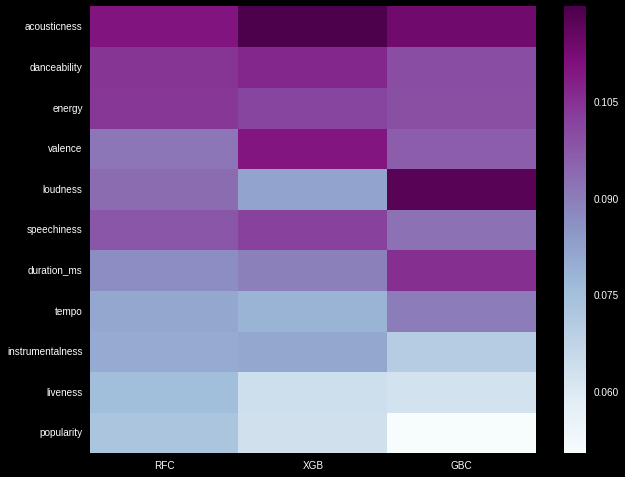

In [29]:
fig, axes = plt.subplots(figsize=(10,8))
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False, 'text.color': 'white', 
             'xtick.color': 'white', 'ytick.color': 'white', 'axes.labelcolor': 'white', 'axes.edgecolor': 'white'} )

sns.heatmap(feature_importances, cmap = 'BuPu')
fig.savefig('feature_importances.png');

In [12]:
confuse = metrics.confusion_matrix(y_test,models['RFC'].predict(X_test))

In [ ]:
mood_list = sorted(moods)
mood_list.remove('Other')

In [ ]:
confuse_df = pd.DataFrame(confuse, index = mood_list, columns = mood_list)

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(confuse_df, annot=True, fmt='g');

In [352]:
pred_probs

array([[ 0.12333333,  0.02666667,  0.08333333, ...,  0.00333333,
         0.08666667,  0.03      ],
       [ 0.00333333,  0.02333333,  0.00333333, ...,  0.01666667,
         0.        ,  0.02333333],
       [ 0.04      ,  0.21666667,  0.03333333, ...,  0.02666667,
         0.01666667,  0.20666667],
       ..., 
       [ 0.00333333,  0.09333333,  0.02666667, ...,  0.03333333,
         0.09666667,  0.33333333],
       [ 0.15      ,  0.05      ,  0.01      , ...,  0.07      ,
         0.11      ,  0.05333333],
       [ 0.00333333,  0.01333333,  0.32      , ...,  0.01      ,
         0.04666667,  0.01333333]])

## Load Pickle Points

In [344]:
with open('data/models.pkl', 'wb') as f:
    pk.dump(models,f,-1)

In [ ]:
with open('data/models.pkl', 'rb') as f:
    models = pk.load(f)

In [353]:
master_songs_scaled.to_pickle('data/master_songs_scaled.pkl')

In [354]:
master_songs_target.to_pickle('data/master_songs_target.pkl')

In [6]:
master_songs_scaled = pd.read_pickle('data/master_songs_scaled.pkl')

In [7]:
master_songs_target = pd.read_pickle('data/master_songs_target.pkl')

## Predicting Arousal Scale (mood_x) 

In [48]:
labels = [-2,-1,0,1,2]

### With Energy

In [49]:
X, y = master_songs_scaled, master_songs_target['mood_x']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=1010)

models_x1 = {}

models_x1['RFC'] = RandomForestClassifier(n_estimators=300)
models_x1['XGB'] = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
models_x1['GBC'] = GradientBoostingClassifier()

for name, model in models_x1.iteritems(): 
    model.fit(X_train, y_train)
    print name
    print metrics.classification_report(y_test, model.predict(X_test))
    print '\n'

RFC
             precision    recall  f1-score   support

         -2       0.60      0.74      0.66       919
         -1       0.51      0.33      0.40      1012
          0       0.52      0.61      0.56      1635
          1       0.52      0.15      0.23       891
          2       0.66      0.82      0.73      1861

avg / total       0.57      0.58      0.55      6318



XGB
             precision    recall  f1-score   support

         -2       0.57      0.75      0.65       919
         -1       0.45      0.28      0.34      1012
          0       0.48      0.57      0.52      1635
          1       0.42      0.09      0.15       891
          2       0.64      0.81      0.71      1861

avg / total       0.53      0.55      0.51      6318



GBC
             precision    recall  f1-score   support

         -2       0.58      0.75      0.66       919
         -1       0.44      0.28      0.34      1012
          0       0.48      0.56      0.52      1635
          1       0.43 

In [50]:
# Create a feature importances comparison chart
feature_importances_x1 = pd.DataFrame()

for name, model in models_x1.iteritems():
    df = pd.DataFrame(data = model.feature_importances_, index = X_test.columns, columns = [name]).transpose()
    feature_importances_x1 = feature_importances_x1.append(df)

feature_importances_x1 = feature_importances_x1.transpose()
feature_importances_x1['average'] = (feature_importances_x1['RFC'] + feature_importances_x1['XGB'] + feature_importances_x1['GBC']) / 3
feature_importances_x1 = feature_importances_x1.sort_values('average', ascending = False).drop('average', axis=1)

confuse_x1 = metrics.confusion_matrix(y_test,models_x1['RFC'].predict(X_test))

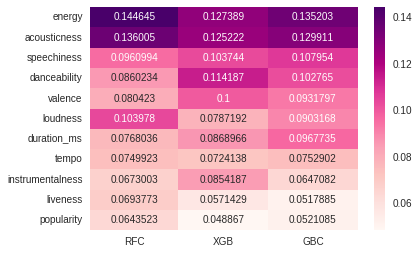

In [51]:
sns.heatmap(feature_importances_x1, cmap = 'RdPu', annot=True, fmt='g');

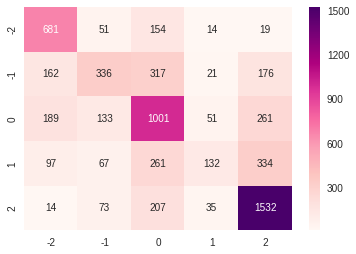

In [52]:
sns.heatmap(confuse_x1, cmap = 'RdPu', annot=True, fmt='g', xticklabels=labels, yticklabels=labels);

In [53]:
with open('data/models_x1.pkl', 'wb') as f:
    pk.dump(models_x1,f,-1)

In [54]:
with open('data/models_x1.pkl', 'rb') as f:
    models_x1 = pk.load(f)

### Without Energy

In [55]:
X, y = master_songs_scaled.drop('energy', axis=1), master_songs_target['mood_x']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=1010)

models_x2 = {}

models_x2['RFC'] = RandomForestClassifier(n_estimators=300)
models_x2['XGB'] = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
models_x2['GBC'] = GradientBoostingClassifier()

for name, model in models_x2.iteritems(): 
    model.fit(X_train, y_train)
    print name
    print metrics.classification_report(y_test, model.predict(X_test))
    print '\n'
    
# Create a feature importances comparison chart
feature_importances_x2 = pd.DataFrame()

for name, model in models_x2.iteritems():
    df = pd.DataFrame(data = model.feature_importances_, index = X_test.columns, columns = [name]).transpose()
    feature_importances_x2 = feature_importances_x2.append(df)

feature_importances_x2 = feature_importances_x2.transpose()
feature_importances_x2['average'] = (feature_importances_x2['RFC'] + feature_importances_x2['XGB'] + feature_importances_x2['GBC']) / 3
feature_importances_x2 = feature_importances_x2.sort_values('average', ascending = False).drop('average', axis=1)

confuse_x2 = metrics.confusion_matrix(y_test,models_x2['RFC'].predict(X_test))

RFC
             precision    recall  f1-score   support

         -2       0.59      0.73      0.66       919
         -1       0.49      0.31      0.38      1012
          0       0.51      0.60      0.55      1635
          1       0.49      0.14      0.22       891
          2       0.65      0.82      0.72      1861

avg / total       0.56      0.57      0.54      6318



XGB
             precision    recall  f1-score   support

         -2       0.56      0.75      0.64       919
         -1       0.47      0.27      0.34      1012
          0       0.48      0.58      0.53      1635
          1       0.40      0.08      0.13       891
          2       0.63      0.81      0.71      1861

avg / total       0.52      0.55      0.51      6318



GBC
             precision    recall  f1-score   support

         -2       0.57      0.74      0.65       919
         -1       0.44      0.27      0.33      1012
          0       0.48      0.57      0.52      1635
          1       0.35 

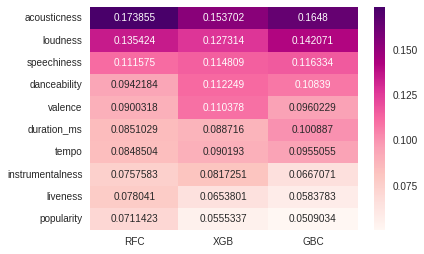

In [56]:
sns.heatmap(feature_importances_x2, cmap = 'RdPu', annot=True, fmt='g');

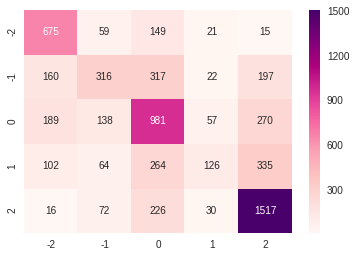

In [57]:
sns.heatmap(confuse_x2, cmap = 'RdPu', annot=True, fmt='g', xticklabels=labels, yticklabels=labels);

#### Save and Load Pickle

In [58]:
with open('data/models_x2.pkl', 'wb') as f:
    pk.dump(models_x2,f,-1)

In [59]:
with open('data/models_x2.pkl', 'rb') as f:
    models_x2 = pk.load(f)

## Predicting Positivity (mood_y)

### With Valence

In [60]:
X, y = master_songs_scaled, master_songs_target['mood_y']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=1010)

models_y1 = {}

models_y1['RFC'] = RandomForestClassifier(n_estimators=300)
models_y1['XGB'] = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
models_y1['GBC'] = GradientBoostingClassifier()

for name, model in models_y1.iteritems(): 
    model.fit(X_train, y_train)
    print name
    print metrics.classification_report(y_test, model.predict(X_test))
    print '\n'

RFC
             precision    recall  f1-score   support

         -2       0.52      0.42      0.47      1220
         -1       0.45      0.59      0.51      1654
          0       0.48      0.54      0.51      1427
          1       0.47      0.44      0.45      1110
          2       0.47      0.27      0.34       907

avg / total       0.48      0.47      0.47      6318



XGB
             precision    recall  f1-score   support

         -2       0.49      0.35      0.41      1220
         -1       0.41      0.55      0.47      1654
          0       0.44      0.51      0.48      1427
          1       0.43      0.45      0.44      1110
          2       0.40      0.20      0.27       907

avg / total       0.44      0.43      0.42      6318



GBC
             precision    recall  f1-score   support

         -2       0.48      0.34      0.40      1220
         -1       0.41      0.54      0.47      1654
          0       0.44      0.52      0.47      1427
          1       0.42 

In [61]:
# Create a feature importances comparison chart
feature_importances_y1 = pd.DataFrame()

for name, model in models_y1.iteritems():
    df = pd.DataFrame(data = model.feature_importances_, index = X_test.columns, columns = [name]).transpose()
    feature_importances_y1 = feature_importances_y1.append(df)

feature_importances_y1 = feature_importances_y1.transpose()
feature_importances_y1['average'] = (feature_importances_y1['RFC'] + feature_importances_y1['XGB'] + feature_importances_y1['GBC']) / 3
feature_importances_y1 = feature_importances_y1.sort_values('average', ascending = False).drop('average', axis=1)

confuse_y1 = metrics.confusion_matrix(y_test,models_y1['RFC'].predict(X_test))

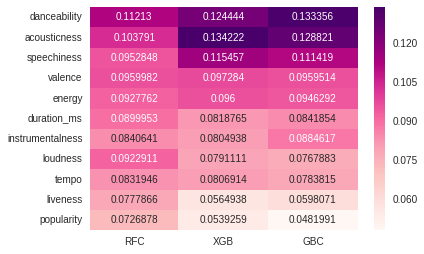

In [62]:
sns.heatmap(feature_importances_y1, cmap = 'RdPu', annot=True, fmt='g');

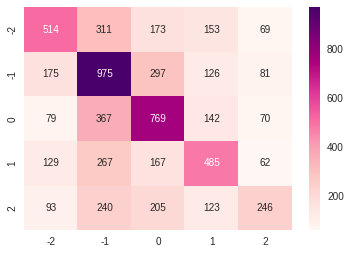

In [63]:
sns.heatmap(confuse_y1, cmap = 'RdPu', annot=True, fmt='g', xticklabels=labels, yticklabels=labels);

In [64]:
with open('data/models_y1.pkl', 'wb') as f:
    pk.dump(models_y1,f,-1)

In [65]:
with open('data/models_y1.pkl', 'rb') as f:
    models_y1 = pk.load(f)

### Without Danceability

In [66]:
X, y = master_songs_scaled.drop('danceability', axis=1), master_songs_target['mood_y']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=1010)

models_y2 = {}

models_y2['RFC'] = RandomForestClassifier(n_estimators=300)
models_y2['XGB'] = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
models_y2['GBC'] = GradientBoostingClassifier()

for name, model in models_y2.iteritems(): 
    model.fit(X_train, y_train)
    print name
    print metrics.classification_report(y_test, model.predict(X_test))
    print '\n'

RFC
             precision    recall  f1-score   support

         -2       0.49      0.40      0.44      1220
         -1       0.44      0.61      0.51      1654
          0       0.46      0.46      0.46      1427
          1       0.45      0.43      0.44      1110
          2       0.43      0.25      0.31       907

avg / total       0.45      0.45      0.44      6318



XGB
             precision    recall  f1-score   support

         -2       0.48      0.34      0.40      1220
         -1       0.40      0.57      0.47      1654
          0       0.41      0.45      0.43      1427
          1       0.42      0.41      0.42      1110
          2       0.37      0.19      0.25       907

avg / total       0.42      0.41      0.41      6318



GBC
             precision    recall  f1-score   support

         -2       0.48      0.33      0.39      1220
         -1       0.40      0.57      0.47      1654
          0       0.41      0.45      0.43      1427
          1       0.42 

In [67]:
# Create a feature importances comparison chart
feature_importances_y2 = pd.DataFrame()

for name, model in models_y2.iteritems():
    df = pd.DataFrame(data = model.feature_importances_, index = X_test.columns, columns = [name]).transpose()
    feature_importances_y2 = feature_importances_y2.append(df)

feature_importances_y2 = feature_importances_y2.transpose()
feature_importances_y2['average'] = (feature_importances_y2['RFC'] + feature_importances_y2['XGB'] + feature_importances_y2['GBC']) / 3
feature_importances_y2 = feature_importances_y2.sort_values('average', ascending = False).drop('average', axis=1)

confuse_y2 = metrics.confusion_matrix(y_test,models_y2['RFC'].predict(X_test))

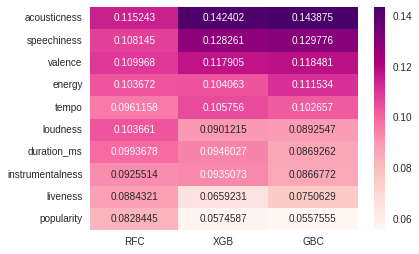

In [68]:
sns.heatmap(feature_importances_y2, cmap = 'RdPu', annot=True, fmt='g');

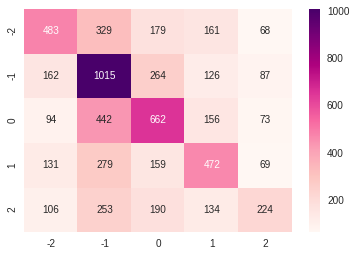

In [69]:
sns.heatmap(confuse_y2, cmap = 'RdPu', annot=True, fmt='g', xticklabels=labels, yticklabels=labels);

## Evaluating Results

In [70]:
## Attempting to remap confusion matrix and classification report
X, y = master_songs_scaled, master_songs_target['mood_1']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=1010)

In [71]:
array_x = models_x1['RFC'].predict(X_test)
x_axis = pd.DataFrame(array_x)

In [72]:
array_y = models_y1['RFC'].predict(X_test)
y_axis = pd.DataFrame(array_y)

In [73]:
array = models['RFC'].predict(X_test)
results = pd.DataFrame(array)

In [74]:
results.head()

,0
0,Energizing
1,Sentimental
2,Excited
3,Empowering
4,Cool


In [75]:
def find_mood(x):
    try: 
        return reverse_mood_map[x]
    except:
        return None

In [76]:
results2 = pd.concat([x_axis, y_axis], axis=1)
results2.columns = ['pred_mood_x', 'pred_mood_y']
results2['pred_mood_map'] = zip(results2['pred_mood_x'],results2['pred_mood_y'])
results2['pred_mood'] = results2['pred_mood_map'].apply(find_mood)

In [77]:
def diagonalsum(m):
    return sum(m[i][i] for i in xrange(len(m)))

In [78]:
confuse = metrics.confusion_matrix(y_test,results)
final_confuse = metrics.confusion_matrix(y_test, np.array(results2['pred_mood']))

In [79]:
print "25 Mood Classification"
print metrics.classification_report(y_test, results)
print "x * y Mood Classification"
print metrics.classification_report(y_test, np.array(results2['pred_mood']))

25 Mood Classification
             precision    recall  f1-score   support

 Aggressive       0.55      0.50      0.53       395
   Brooding       0.32      0.36      0.34       359
       Cool       0.38      0.53      0.44       379
    Defiant       0.44      0.50      0.47       490
  Easygoing       0.36      0.23      0.28       110
 Empowering       0.36      0.52      0.42       477
 Energizing       0.43      0.49      0.46       419
    Excited       0.27      0.35      0.30       384
      Fiery       0.56      0.11      0.19       122
     Gritty       0.33      0.12      0.17       187
     Lively       0.25      0.15      0.19       104
 Melancholy       0.35      0.34      0.35       235
   Peaceful       0.36      0.26      0.30       145
   Romantic       0.42      0.14      0.21       175
      Rowdy       0.25      0.10      0.14       173
    Sensual       0.38      0.49      0.43       500
Sentimental       0.34      0.40      0.37       225
    Serious       0.39

In [80]:
mood_list = sorted(moods)
mood_list.remove('Other')

In [105]:
confuse_df = pd.DataFrame(confuse, index = mood_list, columns = mood_list)

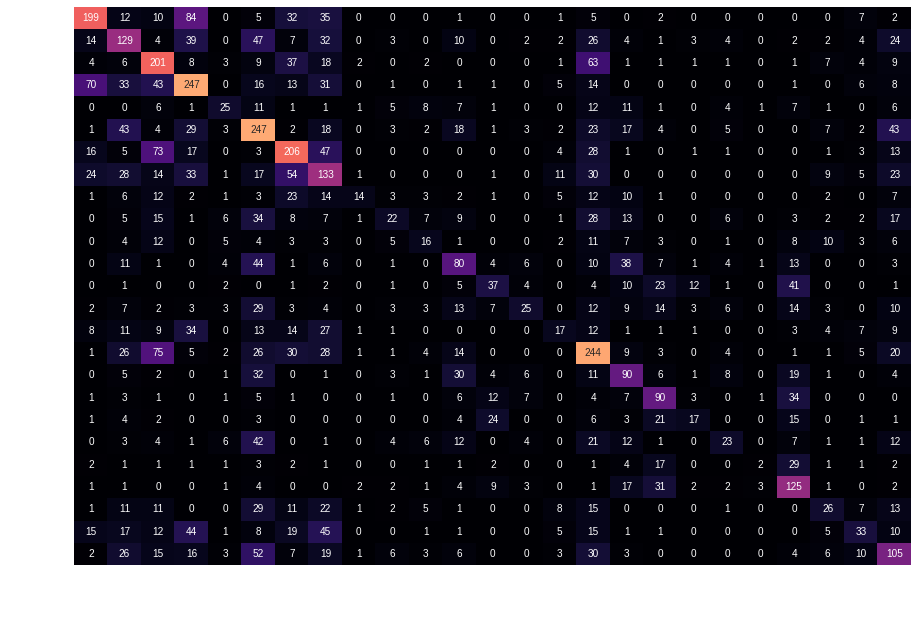

In [115]:
plt.figure(figsize=(15,10))
sns.heatmap(confuse_df, annot=True, fmt='g', cmap = 'magma', cbar=None, vmin=0, vmax=300)
plt.axis('off')
plt.savefig('confuse_df.png', bbox_inches='tight', pad_inches=0)

In [106]:
final_confuse_df = pd.DataFrame(final_confuse, index = mood_list, columns = mood_list)

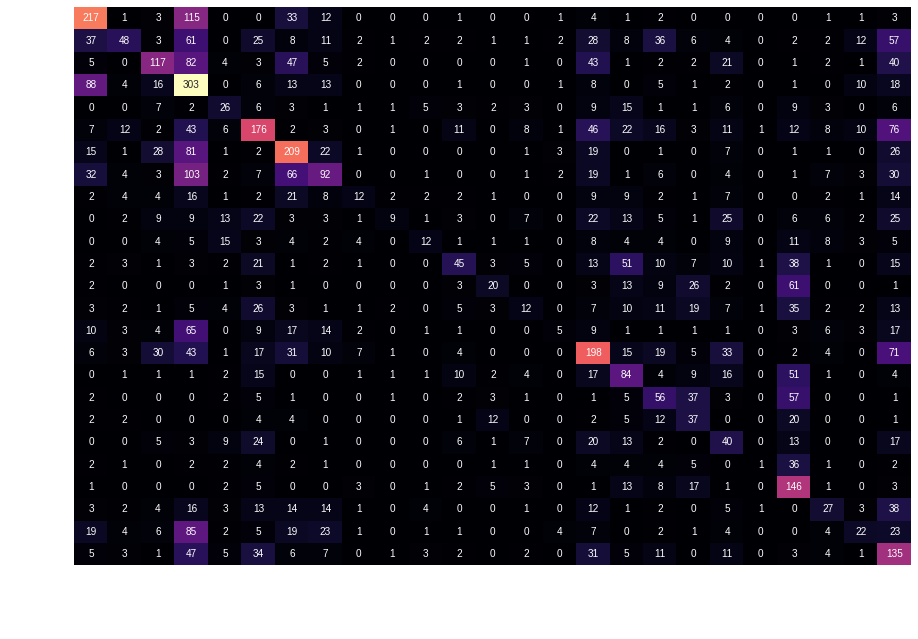

In [116]:
plt.figure(figsize=(15,10))
sns.heatmap(final_confuse_df, annot=True, fmt='g', cmap = 'magma', cbar=None, vmin=0, vmax=300)
plt.axis('off')
plt.savefig('final_confuse_df.png', bbox_inches='tight', pad_inches=0)

In [85]:
results.columns = ['pred_mood']
results['pred_mood_map'] = results['pred_mood'].apply(get_mood_map)

In [86]:
results2.head()

,pred_mood_x,pred_mood_y,pred_mood_map,pred_mood
0,2,0,"(2, 0)",Energizing
1,-2,0,"(-2, 0)",Sentimental
2,2,-1,"(2, -1)",Defiant
3,0,1,"(0, 1)",Empowering
4,-1,-1,"(-1, -1)",Cool


In [ ]:
# sns.heatmap(results['pred_mood_map'], cmap='PuBu', annot=True, fmt='g')

## Prototypes for Production

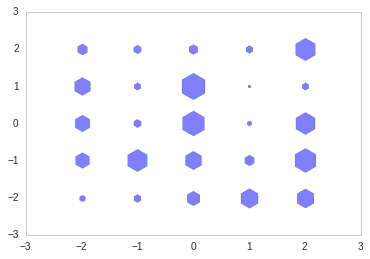

In [301]:
# using 25 mood model
n = results['pred_mood_map'].value_counts()
s = results['pred_mood_map'].value_counts().sum()

fig, axes = plt.subplots()
for coord, value in n.iteritems():
    axes.scatter(coord[0], coord[1], marker='h', s = value, alpha=0.5)
    axes.set_label(s)

In [38]:
mood_list

['Aggressive',
 'Brooding',
 'Cool',
 'Defiant',
 'Easygoing',
 'Empowering',
 'Energizing',
 'Excited',
 'Fiery',
 'Gritty',
 'Lively',
 'Melancholy',
 'Peaceful',
 'Romantic',
 'Rowdy',
 'Sensual',
 'Sentimental',
 'Serious',
 'Somber',
 'Sophisticated',
 'Stirring',
 'Tender',
 'Upbeat',
 'Urgent',
 'Yearning']

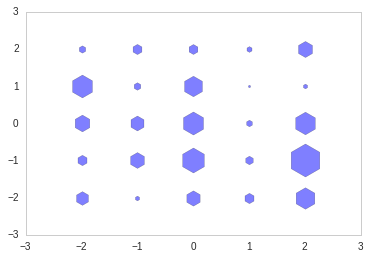

In [303]:
# using model_x * model_y
n = results2['pred_mood_map'].value_counts()
s = results2['pred_mood_map'].value_counts().sum()

colors = np.random.rand(len(n))

fig, axes = plt.subplots()

for coord, value in n.iteritems():
    axes.scatter(coord[0], coord[1], marker='h', s = value, alpha=0.5)
    axes.set_label(s)

In [39]:
for i in mood_list:
    print i

Aggressive
Brooding
Cool
Defiant
Easygoing
Empowering
Energizing
Excited
Fiery
Gritty
Lively
Melancholy
Peaceful
Romantic
Rowdy
Sensual
Sentimental
Serious
Somber
Sophisticated
Stirring
Tender
Upbeat
Urgent
Yearning
